In [223]:
import numpy as np
import matplotlib.pyplot as plt
import abtem
import ase
import dask

from datetime import datetime
#from helper_funcs import timenow_formatted

In [224]:
#timenow = format_time()
#print(timenow)

In [225]:
#setting configuration
abtem.config.set({"device": "gpu", "fft": "fftw"})
dask.config.set({"num_workers": 1})

#! später noch:
SETTINGS -> GPU VERWENDEN!! mit remote connection

- struktur vergrößern (derzeit wieder 10x7 statt 20x20)
- evtl. number configs
- grid_scan: start/ende erweitern

In [226]:
# Parameters and Settings
vacancy_atom = 'B' # enter 'N' for replacement of N-atom, or 'B' for replacement of B-atom
defect_atom_symbol = 'O' # symbol of impurity atom(s)
defect_type = 'single' #'single'/'double' for calculating potential etc with single/double defect
lattice_constant = 2.504 # lattice constant for hBN, https://www.sciencedirect.com/science/article/abs/pii/S0025540815300088
size_x = 10 #size of structure
size_y = 7

#probe #!
energy_probe = 60e3
defocus = 0 # 0 or f.e.: 'scherzer'
semiangle_cutoff = 30 # maybe set to ctf crossover_angle, see below -> probe -> ctf? #!

#benchmark: Cs = -10e-6*1e10; astig = 10; coma = 1000; focal_spread = 10.0; angular_spread = 0.0
Cs = -10e-6*1e10 #spherical aberration; 10 micrometers
astig = 0 #25 aberration C12, ~few nanometers
astig_angle = 0 #+/-0.3 #rad
coma = 1500 #1000 aberration C21, ~few hundred nanometers
#focal_spread = 0.0
#angular_spread = 0.0

#------------------------------------------------------------------------------------------------------------------------------

#preparation for path
now = datetime.now()
now_str = [str(now.year), str(now.month), str(now.day), str(now.hour), str(now.minute), str(now.second),]
#make sure date has same length every time 
for i in range(len(now_str)):
    if len(now_str[i]) == 1:
        now_str[i] = '0' + now_str[i]
now_str = ''.join(now_str)

#path
path = (f'{now_str}_hBN_size{size_x}x{size_y}_{defect_type}_vacany{vacancy_atom}_filledwith{defect_atom_symbol}_energy{int(energy_probe)}_defocus{defocus}_Cs{int(Cs)}_astig{astig}_astigangle{astig_angle}_coma{coma}')#_focal{int(focal_spread)}_ang{int(angular_spread)}')
print(path)

20240809121609_hBN_size10x7_single_vacanyB_filledwithO_energy60000_defocus0_Cs-100000_astig0_astigangle0_coma1500


# Atomic structure & Manipulation

#### Structure

In [227]:
#create hBN cell
hBN_cell = ase.build.graphene(formula='BN', a=lattice_constant, thickness=0.0, size=(1, 1, 1), vacuum=2)


#orthogonalize cell and create structure
hBN_orth = abtem.orthogonalize_cell(hBN_cell)
hBN = hBN_orth*(size_x, size_y, 1) #!

#### Center Atoms

In [228]:
#find atoms located in the center
x_center = max(hBN.positions[:, 0])/2
y_center = max(hBN.positions[:, 1])/2

mask_center_position_x = ((hBN.positions[:,0] < x_center + lattice_constant)*
                          (hBN.positions[:,0] > x_center - lattice_constant))
mask_center_position_y = ((hBN.positions[:,1] < y_center + lattice_constant)*
                          (hBN.positions[:,1] > y_center - lattice_constant))
mask_center = mask_center_position_x * mask_center_position_y

center_indices = (np.asarray(np.where(mask_center == True)))[0]
center_indices.shape

(8,)

#### Single and Double Defects

In [229]:
#SINGLE: find index values in the middle of center index array to adress one (or two) specific atom(s)
ind = int(len(center_indices)/2 - 1) #center_indices.shape = (1,8);
ind_random = center_indices[ind]

#check if chosen atom is wanted single defect type and/or (re-)assign
if hBN.symbols[ind_random] == vacancy_atom:
    ind_single = ind_random
else:
    ind_single = center_indices[ind + 2]
    # +2 because Atoms are saved in the structure [... N N B B N N B...]

#for DOUBLE: make sure, the two atoms are neighbours
#find distance of next neighbours
nnd = round(hBN.get_distance(1, 3),4)

for index in center_indices:
    index_dist = round(hBN.get_distance(ind_single, index),4)
    if index_dist == nnd:
        #found next neighbour -> assign second index
        ind_double = [ind_single, index]
        break
    else:
        pass
    
print(f'Center indices: {center_indices}')
print(f'Chosen index single: {ind_single}')
print(f'Chosen index double: {ind_double}')

Center indices: [124 125 126 127 152 153 154 155]
Chosen index single: 127
Chosen index double: [127, 125]


#### Impurities

In [230]:
#insert impurity atoms - introducing single and double defects
hBN_single = hBN.copy()
hBN_double = hBN.copy()

hBN_single.symbols[ind_single] = defect_atom_symbol
hBN_double.symbols[ind_double] = defect_atom_symbol

# Potential

In [231]:
#RUN BEFORE CALCULATING POTENTIAL
if defect_type == 'double':
    hBN_manipulated = hBN_double
elif defect_type == 'single':
    hBN_manipulated = hBN_single
else:
    raise KeyboardInterrupt

hBN_manipulated

Atoms(symbols='B139N140O', pbc=[True, True, False], cell=[25.04, 30.359386555067278, 4.0])

In [232]:
#implement frozen phonons (average of random offset-snapshots)
frozen_phonons = abtem.FrozenPhonons(hBN_manipulated, num_configs=10, sigmas=0.1) #! num_configs

In [233]:
#create potential (sampling = physical extent/ gridpoints), slice thickness not usefull - no layers
potential = abtem.Potential(frozen_phonons, sampling=0.05)
potential.shape

(10, 4, 501, 608)

In [234]:
#potential.build().compute()

# Probe

In [235]:
#consider partial temporal coherence (due to energy spread of probe) by building gaussian distributed defocus series
#focal_spread = focal_spread
#defocus_distribution = abtem.distributions.gaussian(center=0.0, standard_deviation=focal_spread, num_samples=11,
#                                                    sampling_limit=2, ensemble_mean=False,)
#condider partial spacial coherence (due to source size)
#angular_spread = angular_spread

#create probe and insert parameters for abberations (ctf)
#aberration_coefficients = {'C10': defocus_distribution, 'C30': Cs, 'C12': astig, 'C21': coma}

aberration_coefficients = {'C10': defocus, 'C30': Cs, 'C12': astig, 'C21': coma}

In [236]:
probe = abtem.Probe(energy=energy_probe, semiangle_cutoff=semiangle_cutoff, aberrations=aberration_coefficients, astigmatism_angle=astig_angle) #maybe use crossover angle of ctf for semiangle_cutoff? #!
probe.grid.match(potential)
probe.sampling

(0.04998003992015968, 0.04993320157083434)

In [237]:
probe.build().compute()

[########################################] | 100% Completed | 102.79 ms


# Scan & Detect

In [238]:
#choose Nyquist sampling for scan
sampling = probe.aperture.nyquist_sampling
print(f'Nyquist sampling: {sampling:.3f} Å/pixel')

Nyquist sampling: 0.406 Å/pixel


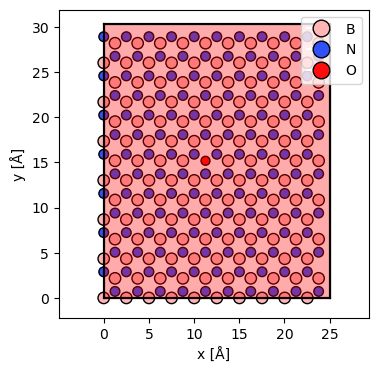

In [239]:
#setup for grid scan
#gridscan = abtem.GridScan(start=[3.5/10, 4/10], end=[6/10, 6/10], fractional = True,
#                     potential=potential, sampling=sampling) 
gridscan = abtem.GridScan(start=[0, 0], end=[10/10, 10/10], fractional = True,
                     potential=potential, sampling=sampling) #!

fig, ax = abtem.show_atoms(hBN_manipulated, figsize=(4,4), legend=True)
gridscan.add_to_plot(ax)

In [240]:
#setup detectors
detector_maadf = abtem.AnnularDetector(inner=60, outer=200)

In [241]:
#apply scan & detectors
measurements_total = probe.scan(potential, scan=gridscan, detectors=detector_maadf)

# Export & Import

In [242]:
#compute and EXPORT... 
measurements_total.to_zarr(f'./data/{path}_RAW.zarr')

#and/or IMPORT from file
imported_measurements = abtem.from_zarr(f'./data/{path}_RAW.zarr')
#imported_measurements = abtem.from_zarr(f'./data/RAW_{path_old}.zarr')
#imported_measurements = abtem.from_zarr('C:/Users/evama/INSERTPATH').compute()
#imported_measurements = abtem.from_zarr('./data/20240808140959_hBN_size10x7_single_vacanyB_filledwithO_energy60000_defocus0_Cs-100000_astig10_coma1000_RAW.zarr').compute()

[########################################] | 100% Completed | 171.85 s


# Postprocessing

In [243]:
#set parameters for postprocessing
#pairs: interpolate:0.01 & gauss: 0.2;  interpolate:0.05 & gauss: 0.3
#interpolate-> higher value (0.1) more pixels; low value -> smoother, more time
interpolate = 0.01
gauss = 0.3
dose = 1e9
#interpol war 0.02; gauss 0.1
#interpol war 0.01; gauss 0.3

path_final = (f'{path}_interpol{interpolate}_gauss{gauss}_dose{dose}')
#path_final = (f'{path_old}_interpol{interpolate}_gauss{gauss}_dose{dose}') #-> for multiple postprocessing versions
print(path_final)

20240809121609_hBN_size10x7_single_vacanyB_filledwithO_energy60000_defocus0_Cs-100000_astig0_astigangle0_coma1500_interpol0.01_gauss0.3_dose1000000000.0


[########################################] | 100% Completed | 105.82 ms


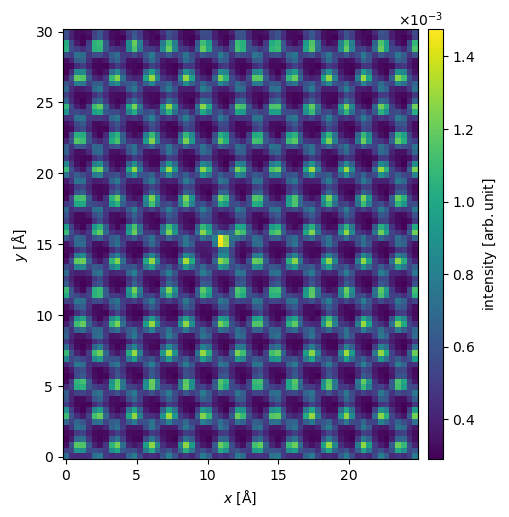

In [244]:
#assign detectors
maadf_measurement = imported_measurements#.integrate_radial(60, 200)

#..and plot
measurements = maadf_measurement
measurements.show(figsize=(14, 5), cbar=True,);

[########################################] | 100% Completed | 2.53 sms


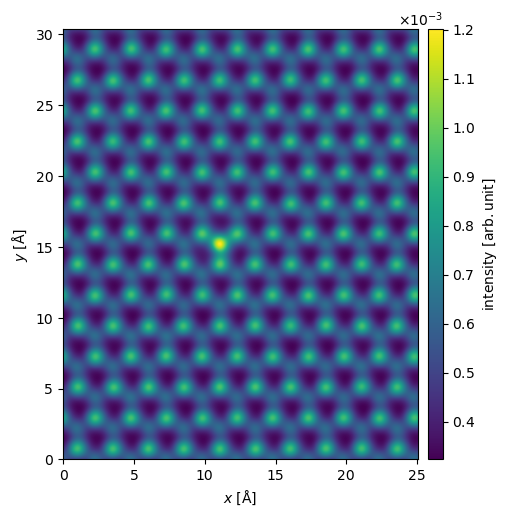

In [245]:
#interpolate to smooth images and apply gaussian filter to consider partial spatial coherence 
final_measurements = measurements.interpolate(interpolate).gaussian_filter(gauss)

#plot
final_measurements.show(explode=True, figsize=(14, 5), cbar=True)

[########################################] | 100% Completed | 3.12 sms


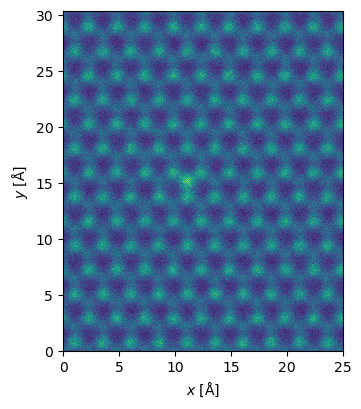

In [246]:
#noise to account for finite electrone dose -> statistic deviation (see abtem walkthrough -> scan & detect)

noisy_measurements = final_measurements.poisson_noise(dose_per_area=dose, seed=100)
noisy_measurements.show(explode=True, figsize=(12, 4))

#zoom in
#plt.xlim(0,2)
#plt.ylim(0,2)

In [247]:
#export
noisy_measurements.to_zarr(f'./data/{path_final}_FINAL.zarr')
#noisy_measurements.to_zarr(f'./data/FINAL2_{path_old}.zarr')

[########################################] | 100% Completed | 3.23 sms


[[None]]

[########################################] | 100% Completed | 102.84 ms


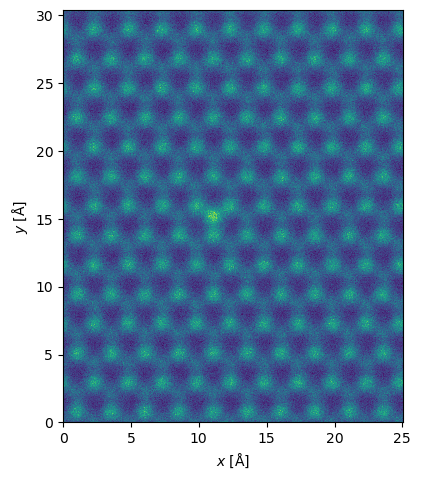

In [248]:
import_new = abtem.from_zarr(f'./data/{path_final}_FINAL.zarr')
import_new.show(explode=True)

In [249]:
#reassign path variable to avoid overwriting
path_old = path
path_final_old = path_final

now = datetime.now()
now_str = [str(now.year), str(now.month), str(now.day), str(now.hour), str(now.minute), str(now.second),]
#make sure date has same length every time 
for i in range(len(now_str)):
    if len(now_str[i]) == 1:
        now_str[i] = '0' + now_str[i]
now_str = ''.join(now_str)

path = (f'{now_str}_hBN_{defect_type}_vacany{vacancy_atom}_filledwith{defect_atom_symbol}_energy{int(energy_probe)}_defocus{defocus}_Cs{int(Cs)}_astig{astig}_coma{coma}')#_focal{int(focal_spread)}_ang{int(angular_spread)}_Date{now.year}{now.month}{now.day}_{now.hour}{now.minute}{now.second}')
path_final = (f'{path}_interpol{interpolate}_gauss{gauss}_dose{dose}')

print(path_old)
print(path)

20240809121609_hBN_size10x7_single_vacanyB_filledwithO_energy60000_defocus0_Cs-100000_astig0_astigangle0_coma1500
20240809121913_hBN_single_vacanyB_filledwithO_energy60000_defocus0_Cs-100000_astig0_coma1500
